In [86]:
from tools import Preprocessing, Clustering

import pandas as pd
import numpy as np

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
import hdbscan

from scipy.cluster import hierarchy


from fancyimpute import KNN
from fancyimpute import MICE
from fancyimpute.bayesian_ridge_regression import BayesianRidgeRegression

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-white')
pd.set_option('display.max_colwidth', -1)

In [2]:
# import the csv dataset as a pandas DataFrame
df = pd.read_csv('data/full_data.csv')
#df.columns

In [3]:
varlist = ['Production_Oil_bpd_2014',
           'Production_Oil_bpd_2015',
           'Production_Oil_bpd_2016',
           'Import_Oil_bpd_2014',
           'Import_Oil_bpd_2015',
           'Import_Oil_bpd_2016',
           'Export_Oil_bdp_2014',
           'Export_Oil_bdp_2015',
           'Export_Oil_bdp_2016',
           'Reserves_Oil_2014',
           'Reserves_Oil_2015',
           'Reserves_Oil_2016'
          ]

In [4]:
prep = Preprocessing('data/full_data.csv',
                     varlist=varlist, verbose=False)
prep.export_csv('data/cleaned_data_petroleum.csv', impute=False)

/home/lupol/dev/clustering-economies/tools.py:104: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.country_names = self.df['Country Name'].as_matrix()


The imported dataset as the following characteristics:
<class 'pandas.core.frame.DataFrame'>
Index: 37 entries, DZA to VNM
Columns: 12 entries, Production_Oil_bpd_2014 to Reserves_Oil_2016
dtypes: float64(12)
memory usage: 3.8+ KB
None
CUMULATIVE PROPORTION OF VARIANCE EXPLAINED BY PCs


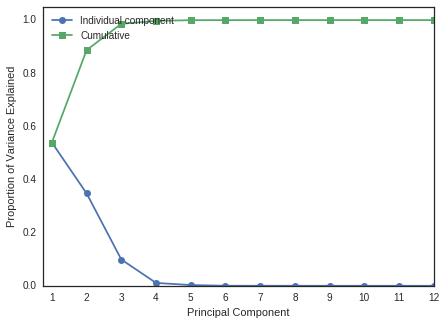

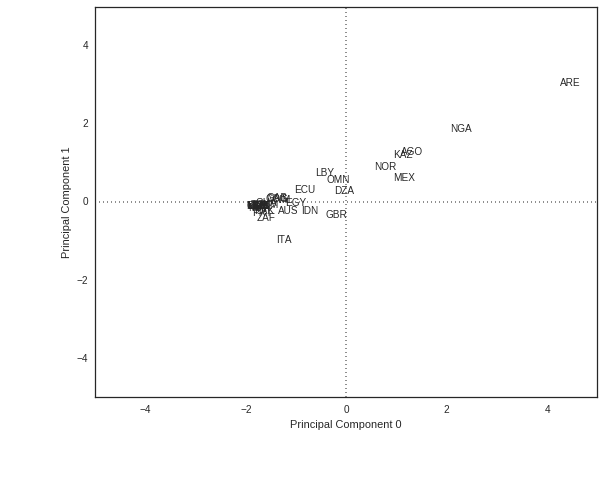

In [5]:
data = Clustering('data/cleaned_data_petroleum.csv')
data.get_PC()
data.plot_along_PC(pc1=0, pc2=1)

Hierarchical clustering with correlation distance metric.


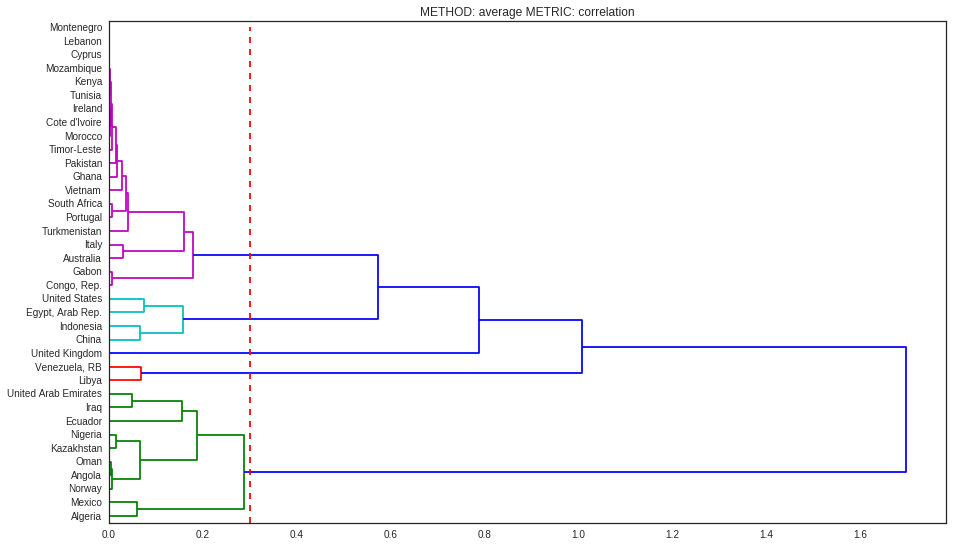

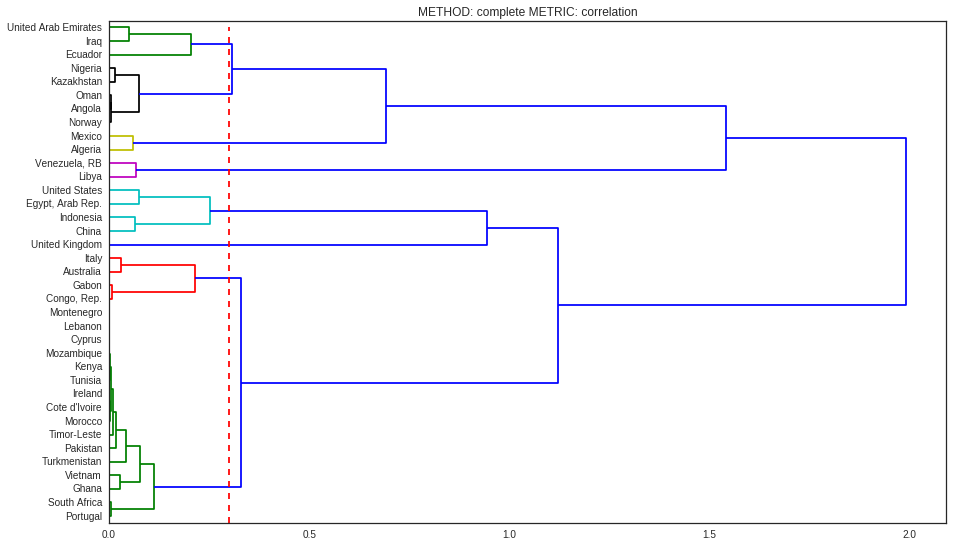

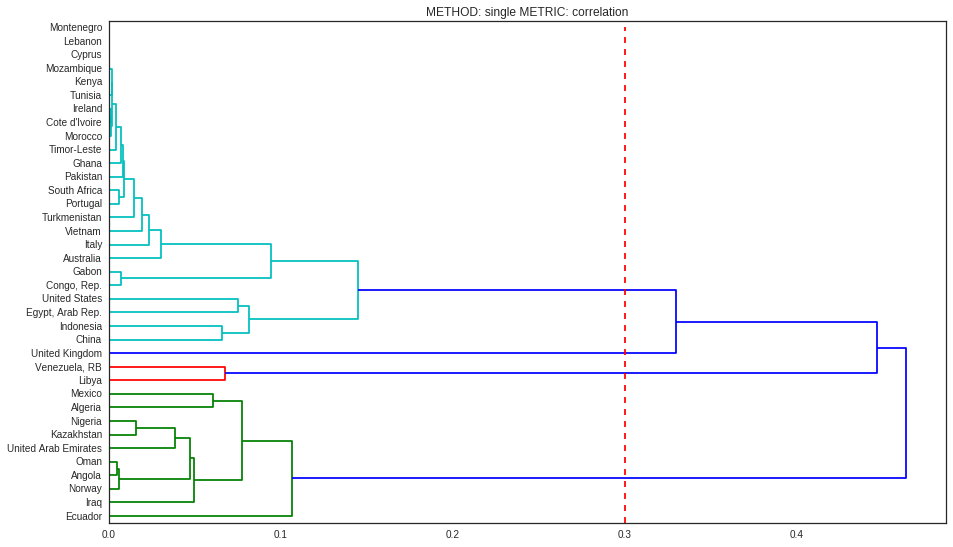

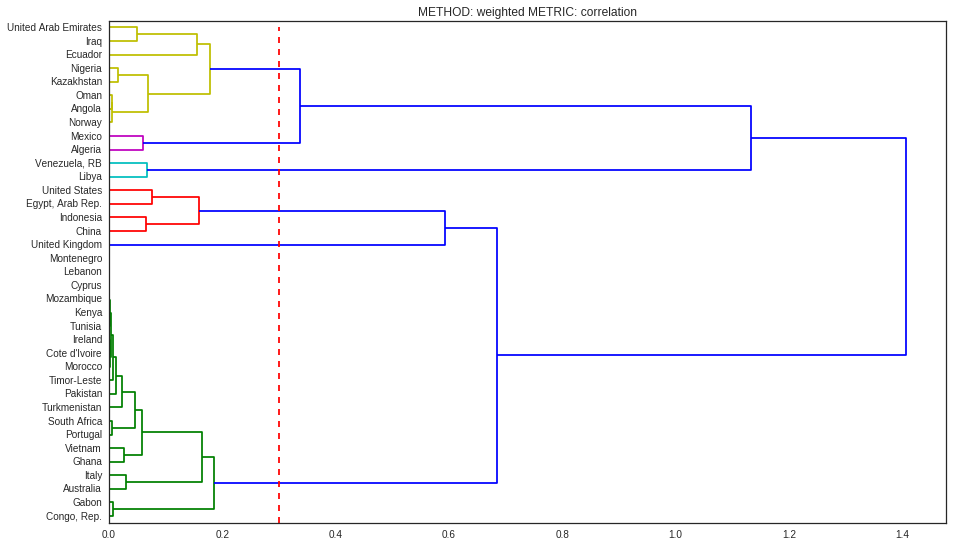

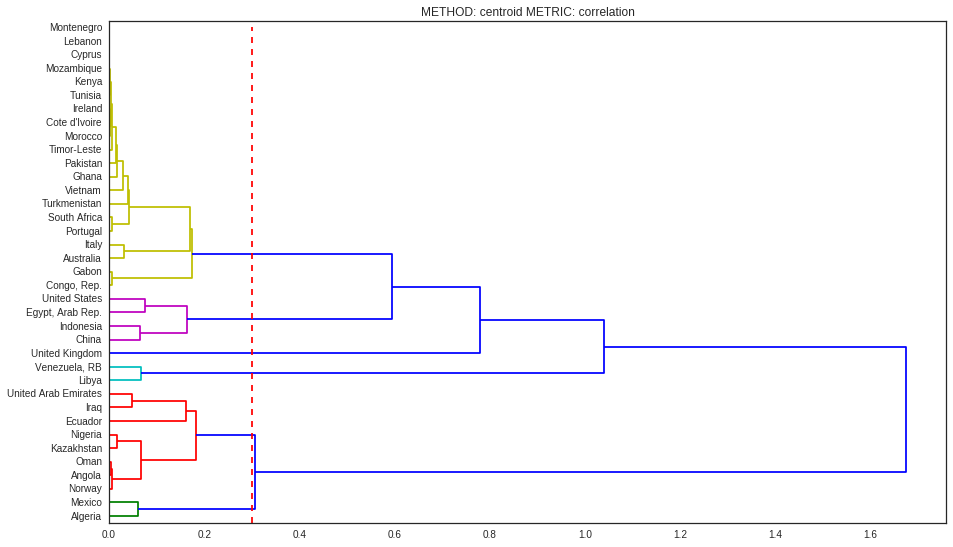

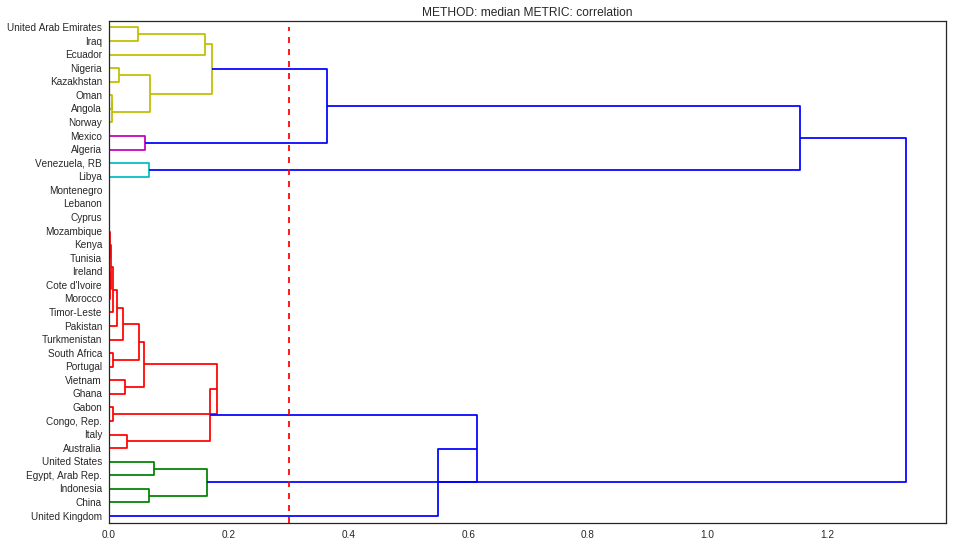

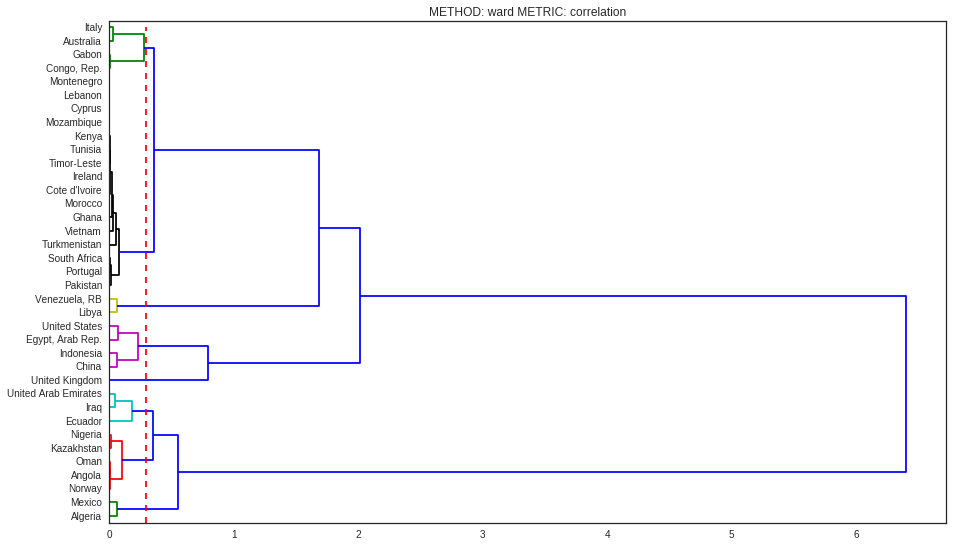

In [6]:
data.hierarchical_clustering(metric='correlation', method='all', threshold=0.3, on_PC=0)

In [90]:
tt = clusters_table(data.clusterings['hierarchical_average_correlation'])

In [91]:
tt

,
Cluster,
1,"[Algeria, Angola, Ecuador, Iraq, Kazakhstan, Mexico, Nigeria, Norway, Oman, United Arab Emirates]"
2,"[Libya, Venezuela, RB]"
3,"[China, Egypt, Arab Rep., Indonesia, United States]"
4,"[Australia, Congo, Rep., Cote d'Ivoire, Cyprus, Gabon, Ghana, Ireland, Italy, Kenya, Lebanon, Montenegro, Morocco, Mozambique, Pakistan, Portugal, South Africa, Timor-Leste, Tunisia, Turkmenistan, Vietnam]"
5,[United Kingdom]


In [8]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=2)
clusterer.fit_predict(data.df)
# Observations per KMeans cluster
cluster_map = pd.DataFrame(columns=['cluster'], index=data.country_names)
cluster_map['cluster'] = clusterer.labels_
cluster_map.sort_values('cluster')

,cluster
Algeria,-1
United States,-1
United Kingdom,-1
United Arab Emirates,-1
South Africa,-1
Oman,-1
Nigeria,-1
"Venezuela, RB",-1
Italy,-1
Iraq,-1
